In [1]:
import os, copy, csv
import numpy as np
import pandas as pd
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import torch, torchvision
from deeplabv3 import FreiburgDataset, FreiburgTestDataset, cf, dn, nut, c2e

<AxesSubplot:xlabel='epoch'>

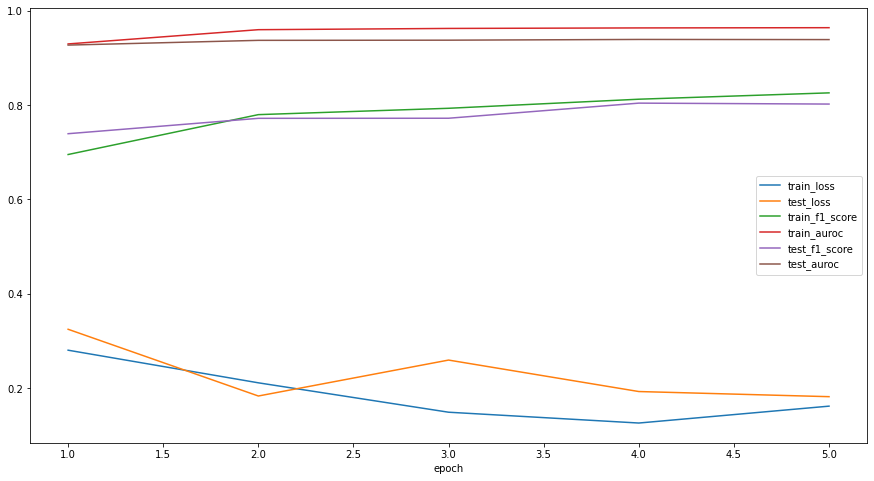

In [2]:
df = pd.read_csv('deeplabv3/results/log.csv')
df.plot(x='epoch',figsize=(15,8))

## Load dataset and sample images

In [2]:
batch_size=4

In [3]:
test_orig_img_shape = (480,640)#(768, 1024)

In [4]:
fd_val = FreiburgDataset("data/freiburg/val")
val_dataloader = torch.utils.data.DataLoader(fd_val, batch_size=batch_size, shuffle=True, collate_fn=cf)
val_img, val_mask = next(iter(val_dataloader))

fd_test = FreiburgTestDataset("data/freiburg/test")
test_dataloader = torch.utils.data.DataLoader(fd_test, batch_size=batch_size, shuffle=False)
test_img = next(iter(test_dataloader))

## Obtain semantic segmentation prediction with Deeplabv3

In [5]:
deeplabv3_model = torch.load('deeplabv3/results/deeplabv3_model.pt', map_location=torch.device('cpu')).to('cpu')
deeplabv3_model.eval()
_=1

In [6]:
with torch.no_grad():
    #val_mask_pred = deeplabv3_model(val_img)['out']
    test_mask_pred = deeplabv3_model(test_img)['out']

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
#val_img = dn(val_img)[0].transpose(1,2,0)
#val_mask = dn(val_mask)[0]
#val_mask_pred = dn(val_mask_pred)[0]

test_img = dn(test_img)
test_mask_pred = nut(dn(test_mask_pred))

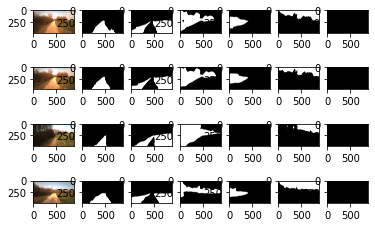

In [8]:
fig,axs=plt.subplots(batch_size,7)
for i in range(batch_size):
    axs[i,0].imshow(c2e(test_img[i]), cmap='gray')
    for j in range(1, 7):
        axs[i,j].imshow(test_mask_pred[i,j-1], cmap='gray')

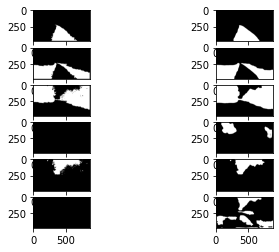

In [10]:
fig,axs=plt.subplots(6,2)
for i in range(6):
    axs[i,0].imshow(val_mask[i], cmap='gray')
    axs[i,1].imshow(nut(val_mask_pred[i]), cmap='gray')

In [8]:
fd_train.obj_names

['Road', 'Grass', 'Vegetation', 'Tree', 'Sky', 'Obstacle']

## Obtain depth prediction with monodepth2

In [9]:
#change transform to match monodepth2's required size
fd_test.transforms = torchvision.transforms.Compose([Image.fromarray,
                                                     lambda x: x.resize((640, 192), Image.LANCZOS), 
                                                     torchvision.transforms.ToTensor()])
test_dataloader2 = torch.utils.data.DataLoader(fd_test, batch_size=batch_size, shuffle=False)
test_img2 = next(iter(test_dataloader2))

In [10]:
from monodepth2 import estimate_depthmap

In [11]:
test_depth_pred = estimate_depthmap(test_img2)

-> Loading model from  models\mono_640x192
   Loading pretrained encoder
   Loading pretrained decoder


In [12]:
test_img2 = dn(test_img2)

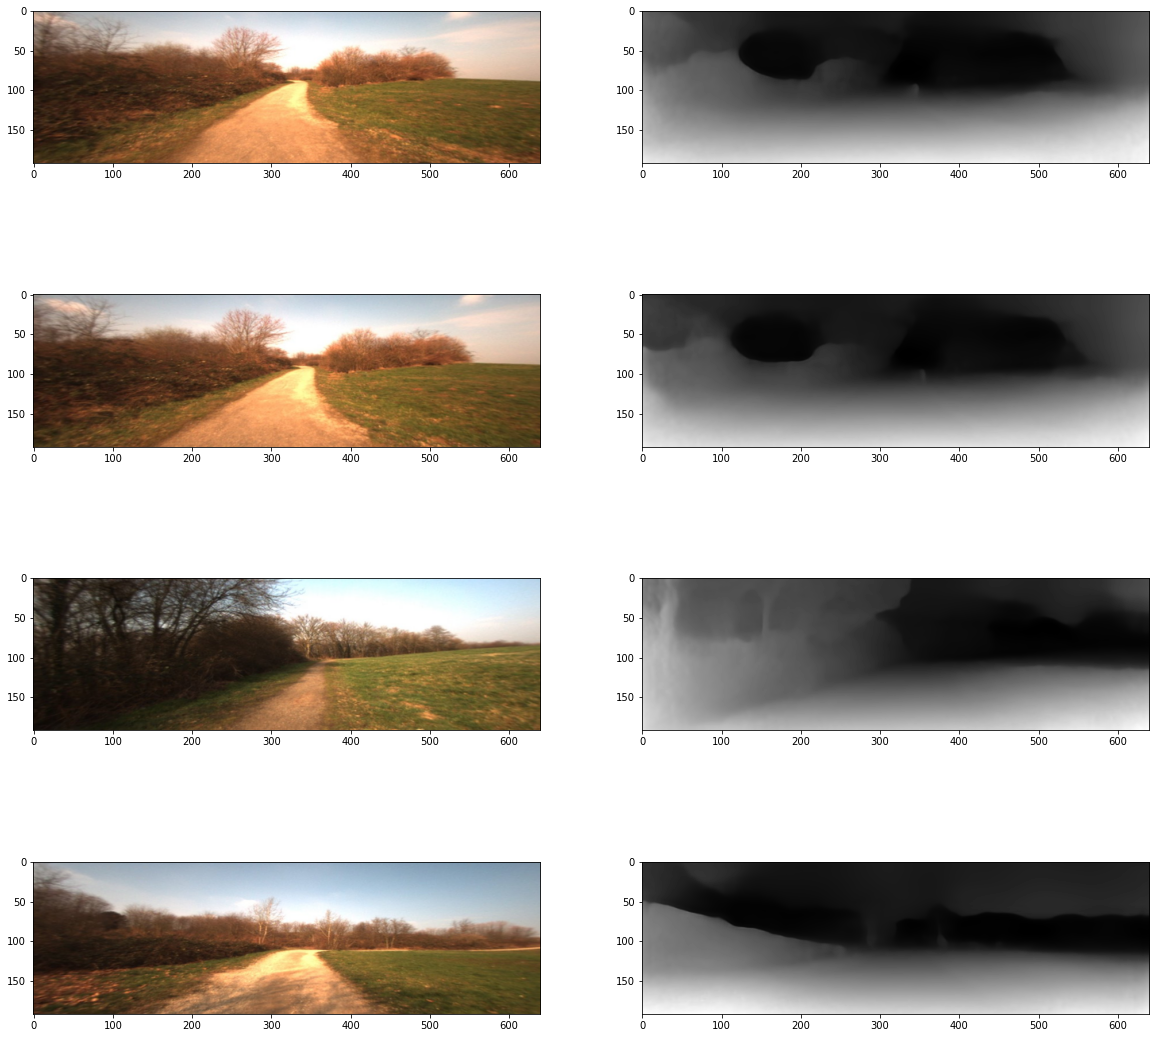

In [13]:
fig,axs=plt.subplots(batch_size,2, figsize=(20,20))
for i in range(batch_size):
    axs[i,0].imshow(c2e(test_img2[i]))
    axs[i,1].imshow(test_depth_pred[i], cmap='gray' )

## Obtain vegetation prediction

In [14]:
#get original images and downsample to 640,480
fd_test.transforms = torchvision.transforms.Compose([Image.fromarray,
                                                     lambda x: x.resize((640, 480), Image.LANCZOS),
                                                     np.array])
test_dataloader3 = torch.utils.data.DataLoader(fd_test, batch_size=batch_size, shuffle=False)
test_img_orig = next(iter(test_dataloader3))

In [15]:
depth_resized = resize(test_depth_pred, (batch_size, 480, 640))
mask_resized  = resize(test_mask_pred,  (batch_size, 6, 480, 640))

In [16]:
from vegetation_index import vegetation_index

In [17]:
index_dict = vegetation_index(mask_resized, depth_resized)

In [18]:
print(index_dict["vegetation"])
print(index_dict["grass"])

[14801.589 12309.928 32346.344  5834.456]
[21544.836 19380.152 19859.238 18752.096]
